# Implementación de Regresión en la Predicción de salarios


### 0. Librerias a Importar y Funciones

In [6]:
# Librerias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn.preprocessing import OneHotEncoder
from collections import Counter

from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from scipy.stats import percentileofscore

from datetime import datetime

%matplotlib inline
import warnings

# Para ignorar un warning específico por categoría
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
#Importando drive para leer los datos
from google.colab import drive
drive.flush_and_unmount()

In [8]:
#Importando drive para leer los datos
drive.mount('/content/drive')

Mounted at /content/drive


### 1. EXPLORACION DE LOS DATOS (10 puntos)
Realicen un análisis preliminar de los predictores y de la variable de respuesta (correlogramas, histogramas y estadísticas descriptivas).

In [9]:
# Leyendo los datos

# Ruta al archivo en Google Drive
ruta_archivo = '/content/drive/My Drive/MIAD/DespliegueSolucionesAnaliticas/Proyecto/data_top10.csv'

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv(ruta_archivo)

# Mostrar las primeras filas para confirmar que se cargó correctamente
print(df.head())


  experience_level employment_type                  job_title  salary_in_usd  \
0               MI              FT             Data Scientist         111740   
1               SE              FT             Data Scientist         115000   
2               SE              FT  Machine Learning Engineer         112000   
3               SE              FT  Machine Learning Engineer         194000   
4               SE              FT             Data Scientist         187000   

  employee_residence  remote_ratio company_location company_size  
0      North America             0    North America            M  
1      North America           100    North America            M  
2      North America             0    North America            M  
3      North America           100    North America            M  
4      North America             0    North America            M  


### Diccionario de Datos
- **work_year**: The year the salary was paid.
- **experience_level**: The experience level in the job during the year with the following possible values:
    - **EN**: Entry-level / Junior
    - **MI**: Mid-level / Intermediate
    - **SE**: Senior-level / Expert
    - **EX**: Executive-level / Director
- **employment_type**: The type of employment for the role:
    - **PT**: Part-time
    - **FT**: Full-time
    - **CT**: Contract
    - **FL**: Freelance
- **job_title**: The role worked in during the year.
- **salary**: The total gross salary amount paid.
- **salary_currency**: The currency of the salary paid as an ISO 4217 currency code.
- **salary_in_usd**: The salary in USD (FX rate divided by avg. USD rate of respective year) via statistical data from the BIS and central banks.
- **employee_residence**: Employee's primary country of residence during the work year as an ISO 3166 country code.
- **remote_ratio**:
  - **description**: The overall amount of work done remotely, possible values are as follows:
    - **0**: No remote work (less than 20%)
    - **50**: Partially remote/hybrid
    - **100**: Fully remote (more than 80%)
- **company_location**: The country of the employer's main office or contracting branch as an ISO 3166 country code.
- **company_size**: The average number of people that worked for the company during the year:
    - **S**: less than 50 employees (small)
    - **M**: 50 to 250 employees (medium)
    - **L**: more than 250 employees (large)

In [10]:
df.tail(3)

,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
11190,SE,FT,Data Scientist,169374,North America,100,North America,M
11191,MI,FT,Data Engineer,305900,North America,100,North America,M
11192,MI,FT,Data Scientist,97060,North America,100,North America,M


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11193 entries, 0 to 11192
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   experience_level    11193 non-null  object
 1   employment_type     11193 non-null  object
 2   job_title           11193 non-null  object
 3   salary_in_usd       11193 non-null  int64 
 4   employee_residence  11193 non-null  object
 5   remote_ratio        11193 non-null  int64 
 6   company_location    11193 non-null  object
 7   company_size        11193 non-null  object
dtypes: int64(2), object(6)
memory usage: 699.7+ KB


In [12]:
duplicate_count = df.duplicated().sum()
duplicate_count

284

In [13]:
df['salary_in_usd'].describe()

,salary_in_usd
count,11193.000000
mean,153545.911373
std,66652.954537
min,16000.000000
25%,101520.000000
50%,145000.000000
75%,198000.000000
max,346500.000000


In [14]:
#Metodos basados en el rango intercuartílico (IQR):
Q1 = df['salary_in_usd'].quantile(0.25)
Q3 = df['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['salary_in_usd'] < Q1 - 1.5 * IQR) | (df['salary_in_usd'] > Q3 + 1.5 * IQR)]


In [15]:
print(outliers)

     experience_level employment_type                  job_title  \
260                SE              FT         Research Scientist   
1023               SE              FT  Machine Learning Engineer   
1662               SE              FT  Machine Learning Engineer   
1789               SE              FT  Machine Learning Engineer   
3917               SE              FT  Machine Learning Engineer   
6484               SE              FT                    Manager   
7694               SE              FT          Software Engineer   
9933               MI              FT                    Manager   

      salary_in_usd employee_residence  remote_ratio company_location  \
260          345000      North America             0    North America   
1023         342844      North America             0    North America   
1662         342844      North America           100    North America   
1789         345400      North America             0    North America   
3917         346500   

#### Comentarios Outliers

- Se identifican 8 outliers, prefiero dejarlos y luego evaluar el impacto en el modelo

#### Preseleccion de Variables

### Separacion XTotal, yTotal

In [16]:
var_seleccionadas = [col for col in df.columns if col != 'salary_in_usd']

# Definir XTotal con todas las columnas menos 'salary_in_usd'
XTotal = df[var_seleccionadas]
yTotal = df.loc[:,df.columns=='salary_in_usd']

In [17]:
XTotal.head()

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,MI,FT,Data Scientist,North America,0,North America,M
1,SE,FT,Data Scientist,North America,100,North America,M
2,SE,FT,Machine Learning Engineer,North America,0,North America,M
3,SE,FT,Machine Learning Engineer,North America,100,North America,M
4,SE,FT,Data Scientist,North America,0,North America,M


In [18]:
XTotal.dtypes

,0
experience_level,object
employment_type,object
job_title,object
employee_residence,object
remote_ratio,int64
company_location,object
company_size,object


### XTrain, XTest, yTrain, yTest

In [19]:
XTotal.head()

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,MI,FT,Data Scientist,North America,0,North America,M
1,SE,FT,Data Scientist,North America,100,North America,M
2,SE,FT,Machine Learning Engineer,North America,0,North America,M
3,SE,FT,Machine Learning Engineer,North America,100,North America,M
4,SE,FT,Data Scientist,North America,0,North America,M


In [20]:
# Convertir variables categóricas a tipo 'category'
XTotal['experience_level'] = XTotal['experience_level'].astype('category')
XTotal['employment_type'] = XTotal['employment_type'].astype('category')
XTotal['job_title'] = XTotal['job_title'].astype('category')
XTotal['employee_residence'] = XTotal['employee_residence'].astype('category')
XTotal['company_location'] = XTotal['company_location'].astype('category')
XTotal['company_size'] = XTotal['company_size'].astype('category')


<ipython-input-20-b17c798596af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XTotal['experience_level'] = XTotal['experience_level'].astype('category')
<ipython-input-20-b17c798596af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XTotal['employment_type'] = XTotal['employment_type'].astype('category')
<ipython-input-20-b17c798596af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [21]:
# Split the data into training and testing sets
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.20, random_state=42)

### LightGBM

In [22]:
import lightgbm as lgb
print(lgb.__version__)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


4.5.0


In [23]:
#Creating model data set
#XTrain, XTest, yTrain, yTest

train_data = lgb.Dataset(XTrain, label=yTrain, categorical_feature=[
    'experience_level', 'employment_type', 'job_title',
    'employee_residence', 'company_location', 'company_size'
],free_raw_data=False)

test_data = lgb.Dataset(XTest, label=yTest, reference=train_data, free_raw_data=False)


In [24]:
#pip install -U lightgbm


#### Cross Validation

In [25]:
#Setting parameters

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 6,
    'verbose': -1,
    'early_stopping_round': 10
}



In [26]:
cv_results = lgb.cv(
    params,
    train_data,
    nfold=5,
    num_boost_round=500,    metrics='rmse',
    seed=42
)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [27]:
print(cv_results)


{'valid rmse-mean': [65376.94369551068, 64001.118512422065, 62850.71336760696, 61897.99038087417, 61104.12108330914, 60457.93134419633, 59919.225051611895, 59479.11473242859, 59116.882336738556, 58825.736314563124, 58584.557661482155, 58382.63409935571, 58219.534616070494, 58082.33753006371, 57971.88172899621, 57879.6980856548, 57804.509471147496, 57739.77415955282, 57686.30886943097, 57646.67501803879, 57612.9868101703, 57581.35401970909, 57555.344022622485, 57533.94394067228, 57512.44977372793, 57499.07196778558, 57487.93734756038, 57478.94003467033, 57471.373137760194, 57463.46203528616, 57459.19541701414, 57458.618401150816, 57452.7742165097, 57451.566407598475, 57451.46832989841, 57447.30447340906, 57445.61416323851, 57442.962106015955, 57446.14444875474, 57449.25342662926, 57450.14553871199, 57448.73765655137, 57445.93790470401, 57445.52775745002, 57443.015793014165, 57443.438267986756, 57442.65495178191, 57442.57170275789, 57442.53115146968, 57442.136825560374, 57441.48199784807

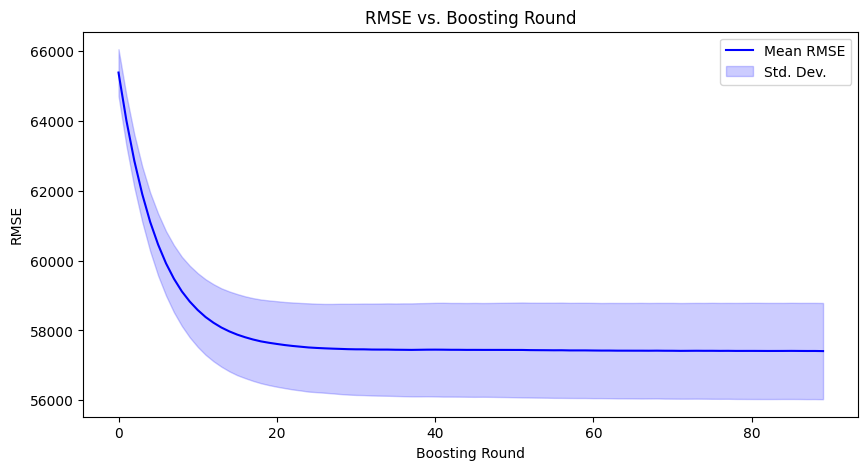

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to NumPy arrays for element-wise operations
rmse_mean = np.array(cv_results['valid rmse-mean'])
rmse_stdv = np.array(cv_results['valid rmse-stdv'])

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(rmse_mean, label='Mean RMSE', color='blue')
plt.fill_between(range(len(rmse_mean)),
                 rmse_mean - rmse_stdv,
                 rmse_mean + rmse_stdv,
                 alpha=0.2, color='blue', label='Std. Dev.')
plt.title('RMSE vs. Boosting Round')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.show()



In [29]:
num_round = 20  # Número de iteraciones
model1 = lgb.train(params, train_data, num_round, valid_sets=[test_data])


In [30]:
y_pred1 = model1.predict(XTest, num_iteration=model1.best_iteration)

In [31]:
from sklearn.metrics import mean_squared_error

rmse1 = np.sqrt(mean_squared_error(yTest, y_pred1))
print(f'RMSE: {rmse1}')


RMSE: 55815.281648134085


#### GridSearch *1*

In [34]:
#XTrain, XTest, yTrain, yTest
from sklearn.model_selection import GridSearchCV
param_grid = {
    'num_leaves': [5, 10, 15, 31, 40, 64, 128],
    'max_depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.1, 0.25, 0.30],
    'min_data_in_leaf': [5, 10, 15, 20]
}
modelGS1 = lgb.LGBMRegressor()
grid_search1 = GridSearchCV(modelGS1, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search1.fit(XTrain, yTrain)



GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.25, 0.3],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_data_in_leaf': [5, 10, 15, 20],
                         'num_leaves': [5, 10, 15, 31, 40, 64, 128]},
             scoring='neg_mean_squared_error')

In [33]:
best_params1 = grid_search1.best_params_
print("Best parameters:1", best_params1)


Best parameters: {'learning_rate': 0.3, 'max_depth': 4, 'min_data_in_leaf': 20, 'num_leaves': 5}


#### GridSearch *2*

In [38]:
param_grid2 = {
    'num_leaves': [5,10, 15, 31],
    'max_depth': [4,6, 8, 10,12],
    'learning_rate': [0.01, 0.1, 0.25]
}
modelGS2 = lgb.LGBMRegressor()
grid_search2 = GridSearchCV(modelGS2, param_grid2, cv=5, scoring='neg_mean_squared_error')
grid_search2.fit(XTrain, yTrain)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.25],
                         'max_depth': [4, 6, 8, 10, 12],
                         'num_leaves': [5, 10, 15, 31]},
             scoring='neg_mean_squared_error')

In [39]:
best_params2 = grid_search2.best_params_
print("Best parameters 2:", best_params2)

Best parameters 2: {'learning_rate': 0.25, 'max_depth': 4, 'num_leaves': 15}
